In [1]:
from preprocess import hdf5_writer
import torch
import h5py

# Create a random "Test Volume" file manually.

In [ ]:
width = 512
height = 512
depth = 512

chunk_size = 128
test_volume = torch.randn(depth, height, width)

In [ ]:
output_file = "test_volume.h5"

n_chunks_x = (width + chunk_size - 1) // chunk_size
n_chunks_y = (height + chunk_size - 1) // chunk_size
n_chunks_z = (depth + chunk_size - 1) // chunk_size

# Define chunk coordinates and shapes
chunk_shapes = {}
xy_chunk_coords = [(cy, cx) for cy in range(n_chunks_y) for cx in range(n_chunks_x)]
for cy in range(n_chunks_y):
    for cx in range(n_chunks_x):
        x_start = cx * chunk_size
        y_start = cy * chunk_size
        x_end = min(x_start + chunk_size, width)
        y_end = min(y_start + chunk_size, height)
        for cz in range(n_chunks_z):
            z_start = cz * chunk_size
            z_end = min(z_start + chunk_size, depth)
            chunk_shapes[(cy, cx, cz)] = (y_end - y_start, x_end - x_start, z_end - z_start)

with h5py.File(output_file, "w") as f:
    # Initialize datasets for each chunk in the 3D grid
    datasets = {}
    for (cy, cx, cz), (h, w, d) in chunk_shapes.items():
        ds_name = f"chunk_{cy}_{cx}_{cz}"
        datasets[(cy, cx, cz)] = f.create_dataset(
            ds_name,
            shape=(h, w, d),
            chunks=(h, w, 1),  # Small z-chunk for appending efficiency
            dtype="float16",  # Adjust dtype based on your data
        )
    
    # Write the data to the datasets
    for (cy, cx, cz), (h, w, d) in chunk_shapes.items():
        x_start = cx * chunk_size
        y_start = cy * chunk_size
        z_start = cz * chunk_size
        x_end = min(x_start + chunk_size, width)
        y_end = min(y_start + chunk_size, height)
        z_end = min(z_start + chunk_size, depth)
        
        # Extract the corresponding slice from the test volume
        data_slice = test_volume[z_start:z_end, y_start:y_end, x_start:x_end]
        
        # Write the slice to the dataset
        datasets[(cy, cx, cz)][...] = data_slice.float().numpy()  # Convert to numpy and write
    print(f"Data written to {output_file} in chunks.")


Data written to test_volume.h5 in chunks.


In [1]:
from reader import HDF5Volume

disk_volume = HDF5Volume("test_volume.h5")

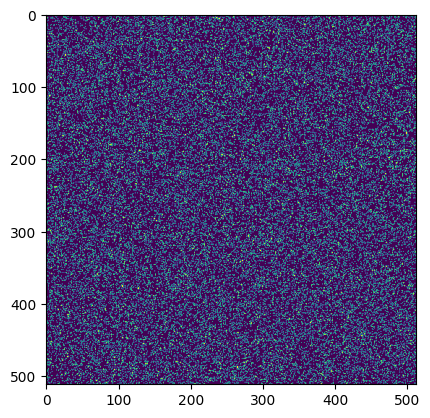

In [3]:
import matplotlib.pyplot as plt

plt.imshow(disk_volume[0, :, :][0])